# Decision Tree Regression Analysis for Social Media Addiction Prediction

### Ahmad Tsaqif Imtinan - 5025221131
This notebook implements Decision Tree Regression to predict social media addiction levels using pre-processed student data. Exploring various scenarios including Feature Selection, Normalization, Parameter Tuning, and model optimization.

## Objectives:
1. **Testing Feature Selection**: Comparing models with and without Feature Selection
2. **Normalization Testing**: Comparing models with and without data normalization
3. **Parameter Tuning**: Optimizing the Decision Tree hyperparameters
4. **Performance Analysis**: Evaluating the performance of the model across different configurations

In [72]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [73]:
# Load the preprocessed dataset
data = pd.read_csv('../dataset/Students_Social_Media_Addiction_Feature_Engineered.csv')

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

print("\nDataset Info:")
print(data.info())

print("\nTarget Variable Statistics:")
print(data['Addicted_Score'].describe())

Dataset Shape: (705, 25)

First 5 rows:
   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score

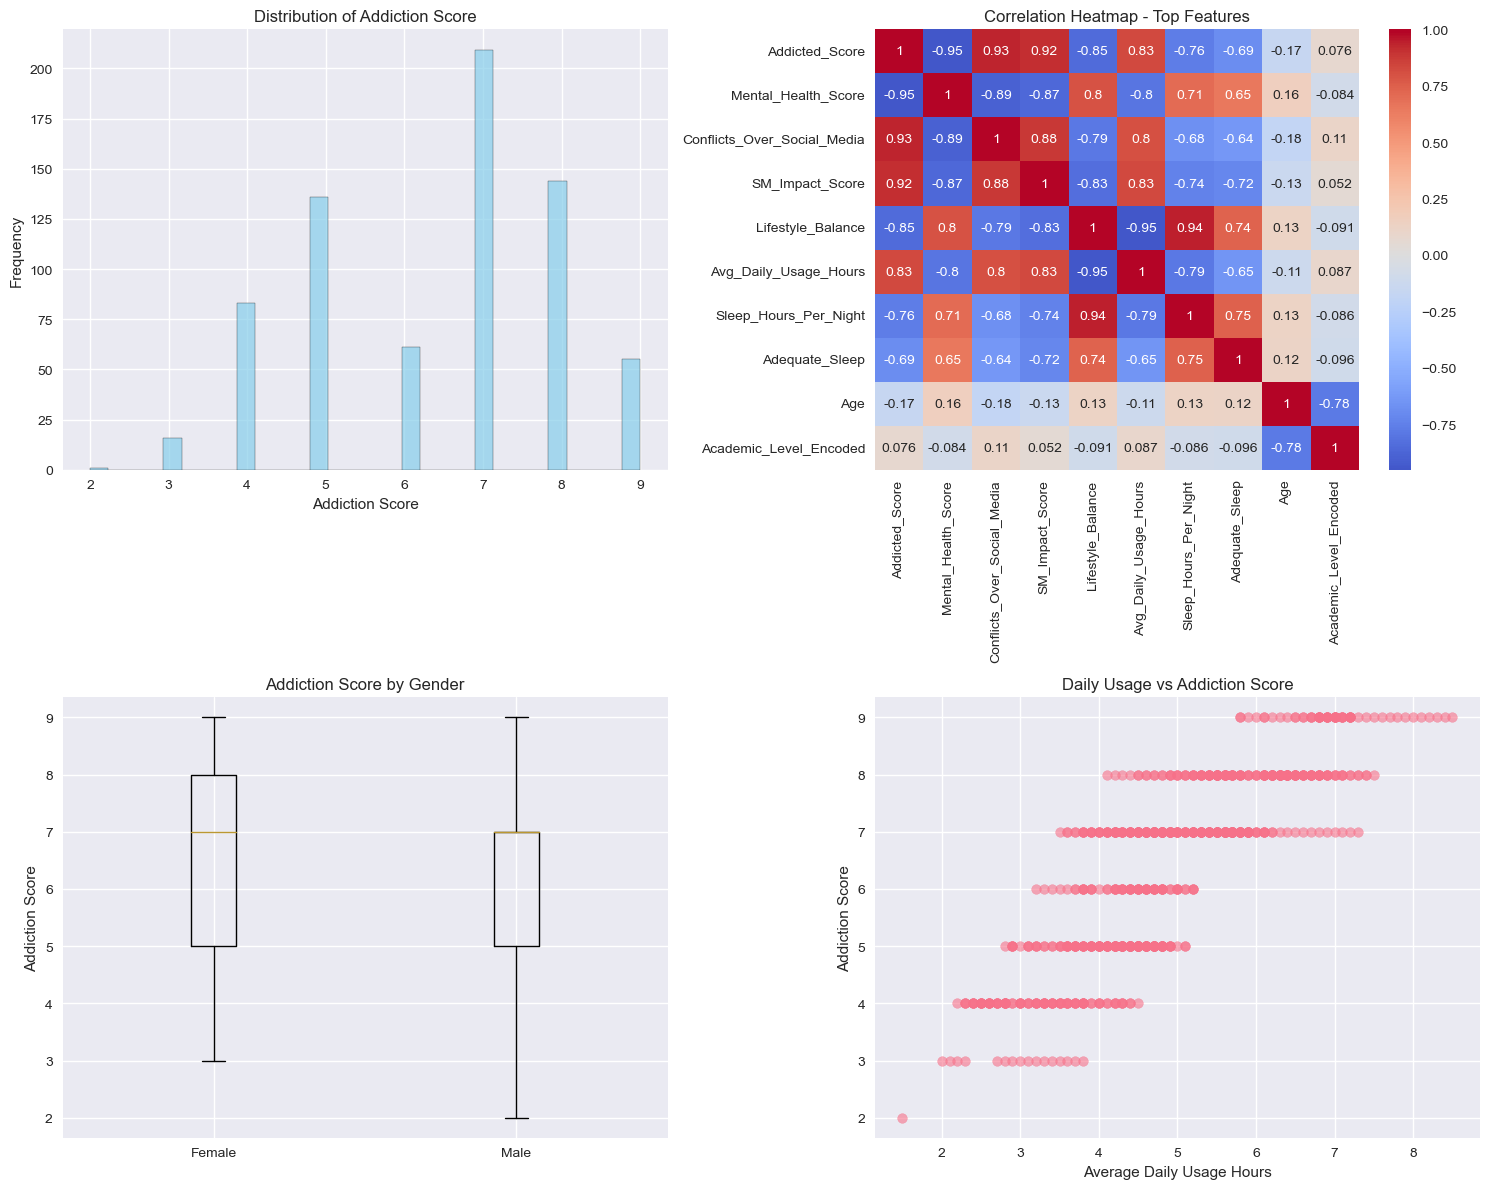

Top 10 features correlated with Addiction Score:
Addicted_Score                 1.000000
Mental_Health_Score            0.945051
Conflicts_Over_Social_Media    0.933586
SM_Impact_Score                0.915776
Lifestyle_Balance              0.845623
Avg_Daily_Usage_Hours          0.832000
Sleep_Hours_Per_Night          0.764858
Adequate_Sleep                 0.690550
Age                            0.166396
Academic_Level_Encoded         0.075543
Name: Addicted_Score, dtype: float64


In [74]:
# Data Exploration and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Target variable distribution
axes[0, 0].hist(data['Addicted_Score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Addiction Score')
axes[0, 0].set_xlabel('Addiction Score')
axes[0, 0].set_ylabel('Frequency')

# Correlation heatmap of top features with target
numeric_cols = data.select_dtypes(include=[np.number]).columns
corr_with_target = data[numeric_cols].corr()['Addicted_Score'].abs().sort_values(ascending=False)[:10]
top_features = corr_with_target.index

sns.heatmap(data[top_features].corr(), annot=True, cmap='coolwarm', center=0, ax=axes[0, 1])
axes[0, 1].set_title('Correlation Heatmap - Top Features')

# Box plot of addiction score by gender
axes[1, 0].boxplot([data[data['Gender_Encoded'] == 0]['Addicted_Score'],
                   data[data['Gender_Encoded'] == 1]['Addicted_Score']], 
                  labels=['Female', 'Male'])
axes[1, 0].set_title('Addiction Score by Gender')
axes[1, 0].set_ylabel('Addiction Score')

# Scatter plot: Daily Usage vs Addiction Score
axes[1, 1].scatter(data['Avg_Daily_Usage_Hours'], data['Addicted_Score'], alpha=0.6)
axes[1, 1].set_xlabel('Average Daily Usage Hours')
axes[1, 1].set_ylabel('Addiction Score')
axes[1, 1].set_title('Daily Usage vs Addiction Score')

plt.tight_layout()
plt.show()

print("Top 10 features correlated with Addiction Score:")
print(corr_with_target)

In [75]:
# Prepare Data for Modeling
# Separate features and target
X_all = data.drop('Addicted_Score', axis=1)
y = data['Addicted_Score']

# Select only numeric columns for modeling (exclude categorical string columns)
# Keep the encoded versions instead of original categorical columns
columns_to_exclude = ['Student_ID', 'Gender', 'Academic_Level', 'Country', 
                     'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']
X = X_all.drop(columns=columns_to_exclude)

print("Feature columns after removing categorical string columns:")
print(X.columns.tolist())
print(f"\nNumber of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# Verify all columns are numeric
print(f"\nData types of features:")
print(X.dtypes)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Feature columns after removing categorical string columns:
['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Adequate_Sleep', 'Gender_Encoded', 'Academic_Level_Encoded', 'Relationship_Status_Encoded', 'SM_Impact_Score', 'Lifestyle_Balance', 'Usage_Category_Medium', 'Usage_Category_High', 'Usage_Category_Very High', 'Mental_Health_Risk_Medium', 'Mental_Health_Risk_Low', 'Mental_Health_Risk_Very Low']

Number of features: 17
Number of samples: 705

Data types of features:
Age                              int64
Avg_Daily_Usage_Hours          float64
Sleep_Hours_Per_Night          float64
Mental_Health_Score              int64
Conflicts_Over_Social_Media      int64
Adequate_Sleep                   int64
Gender_Encoded                   int64
Academic_Level_Encoded           int64
Relationship_Status_Encoded      int64
SM_Impact_Score                float64
Lifestyle_Balance              float64
Usage_Category_Medium            

In [76]:
# Define Evaluation Functions
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Evaluate a regression model and return metrics
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results = {
        'Model': model_name,
        'Train_MSE': train_mse,
        'Test_MSE': test_mse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std(),
        'Overfitting': train_r2 - test_r2
    }
    
    return results

def print_results(results):
    """
    Print formatted results
    """
    print(f"\n=== {results['Model']} Results ===")
    print(f"Train MSE: {results['Train_MSE']:.4f}")
    print(f"Test MSE: {results['Test_MSE']:.4f}")
    print(f"Train MAE: {results['Train_MAE']:.4f}")
    print(f"Test MAE: {results['Test_MAE']:.4f}")
    print(f"Train R²: {results['Train_R2']:.4f}")
    print(f"Test R²: {results['Test_R2']:.4f}")
    print(f"CV R² (Mean ± Std): {results['CV_R2_Mean']:.4f} ± {results['CV_R2_Std']:.4f}")
    print(f"Overfitting (Train R² - Test R²): {results['Overfitting']:.4f}")

## Scenario 1: Feature Selection Testing

Comparing decision tree performance with and without feature selection using different methods:
1. **No Feature Selection**: Using all available features
2. **SelectKBest**: Selecting top K features based on statistical tests
3. **Recursive Feature Elimination (RFE)**: Iteratively selecting features
4. **Correlation-based Selection**: Selecting features based on correlation with target

In [77]:
# Feature Selection Methods

# 1. No Feature Selection (Baseline)
print("=== Feature Selection Analysis ===")
print(f"Original number of features: {X_train.shape[1]}")

# 2. SelectKBest Feature Selection
selector_kbest = SelectKBest(score_func=f_regression, k=15)
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
X_test_kbest = selector_kbest.transform(X_test)

selected_features_kbest = X.columns[selector_kbest.get_support()]
print(f"\nSelectKBest selected features ({len(selected_features_kbest)}):")
print(selected_features_kbest.tolist())

# 3. Recursive Feature Elimination
dt_for_rfe = DecisionTreeRegressor(random_state=42)
selector_rfe = RFE(estimator=dt_for_rfe, n_features_to_select=15)
X_train_rfe = selector_rfe.fit_transform(X_train, y_train)
X_test_rfe = selector_rfe.transform(X_test)

selected_features_rfe = X.columns[selector_rfe.support_]
print(f"\nRFE selected features ({len(selected_features_rfe)}):")
print(selected_features_rfe.tolist())

# 4. Correlation-based Feature Selection
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
top_15_corr_features = correlations.head(15).index
X_train_corr = X_train[top_15_corr_features]
X_test_corr = X_test[top_15_corr_features]

print(f"\nTop 15 correlation-based features:")
print(top_15_corr_features.tolist())
print(f"\nCorrelation values:")
print(correlations.head(15))

=== Feature Selection Analysis ===
Original number of features: 17

SelectKBest selected features (15):
['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Adequate_Sleep', 'Gender_Encoded', 'Academic_Level_Encoded', 'SM_Impact_Score', 'Lifestyle_Balance', 'Usage_Category_Medium', 'Usage_Category_High', 'Usage_Category_Very High', 'Mental_Health_Risk_Medium', 'Mental_Health_Risk_Low']

RFE selected features (15):
['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Gender_Encoded', 'Academic_Level_Encoded', 'Relationship_Status_Encoded', 'SM_Impact_Score', 'Lifestyle_Balance', 'Usage_Category_Medium', 'Usage_Category_High', 'Usage_Category_Very High', 'Mental_Health_Risk_Medium', 'Mental_Health_Risk_Low']

Top 15 correlation-based features:
['Mental_Health_Score', 'Conflicts_Over_Social_Media', 'SM_Impact_Score', 'Mental_Health_Risk_Low', 'Lifestyle_Balance', 'Avg_Da

In [78]:
# Compare Decision Tree Models with Different Feature Selection Methods
feature_selection_results = []

# Model 1: No Feature Selection
dt_no_fs = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_no_fs.fit(X_train, y_train)
results_no_fs = evaluate_model(dt_no_fs, X_train, X_test, y_train, y_test, "No Feature Selection")
feature_selection_results.append(results_no_fs)
print_results(results_no_fs)

# Model 2: SelectKBest
dt_kbest = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_kbest.fit(X_train_kbest, y_train)
results_kbest = evaluate_model(dt_kbest, X_train_kbest, X_test_kbest, y_train, y_test, "SelectKBest (15 features)")
feature_selection_results.append(results_kbest)
print_results(results_kbest)

# Model 3: RFE
dt_rfe = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_rfe.fit(X_train_rfe, y_train)
results_rfe = evaluate_model(dt_rfe, X_train_rfe, X_test_rfe, y_train, y_test, "RFE (15 features)")
feature_selection_results.append(results_rfe)
print_results(results_rfe)

# Model 4: Correlation-based
dt_corr = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_corr.fit(X_train_corr, y_train)
results_corr = evaluate_model(dt_corr, X_train_corr, X_test_corr, y_train, y_test, "Correlation-based (15 features)")
feature_selection_results.append(results_corr)
print_results(results_corr)


=== No Feature Selection Results ===
Train MSE: 0.0051
Test MSE: 0.2675
Train MAE: 0.0103
Test MAE: 0.1291
Train R²: 0.9980
Test R²: 0.8931
CV R² (Mean ± Std): 0.9524 ± 0.0099
Overfitting (Train R² - Test R²): 0.1049

=== SelectKBest (15 features) Results ===
Train MSE: 0.0084
Test MSE: 0.1471
Train MAE: 0.0168
Test MAE: 0.1520
Train R²: 0.9967
Test R²: 0.9412
CV R² (Mean ± Std): 0.9510 ± 0.0088
Overfitting (Train R² - Test R²): 0.0554

=== RFE (15 features) Results ===
Train MSE: 0.0061
Test MSE: 0.1077
Train MAE: 0.0121
Test MAE: 0.1094
Train R²: 0.9976
Test R²: 0.9570
CV R² (Mean ± Std): 0.9555 ± 0.0046
Overfitting (Train R² - Test R²): 0.0406

=== Correlation-based (15 features) Results ===
Train MSE: 0.0084
Test MSE: 0.1258
Train MAE: 0.0168
Test MAE: 0.1307
Train R²: 0.9967
Test R²: 0.9497
CV R² (Mean ± Std): 0.9465 ± 0.0100
Overfitting (Train R² - Test R²): 0.0469


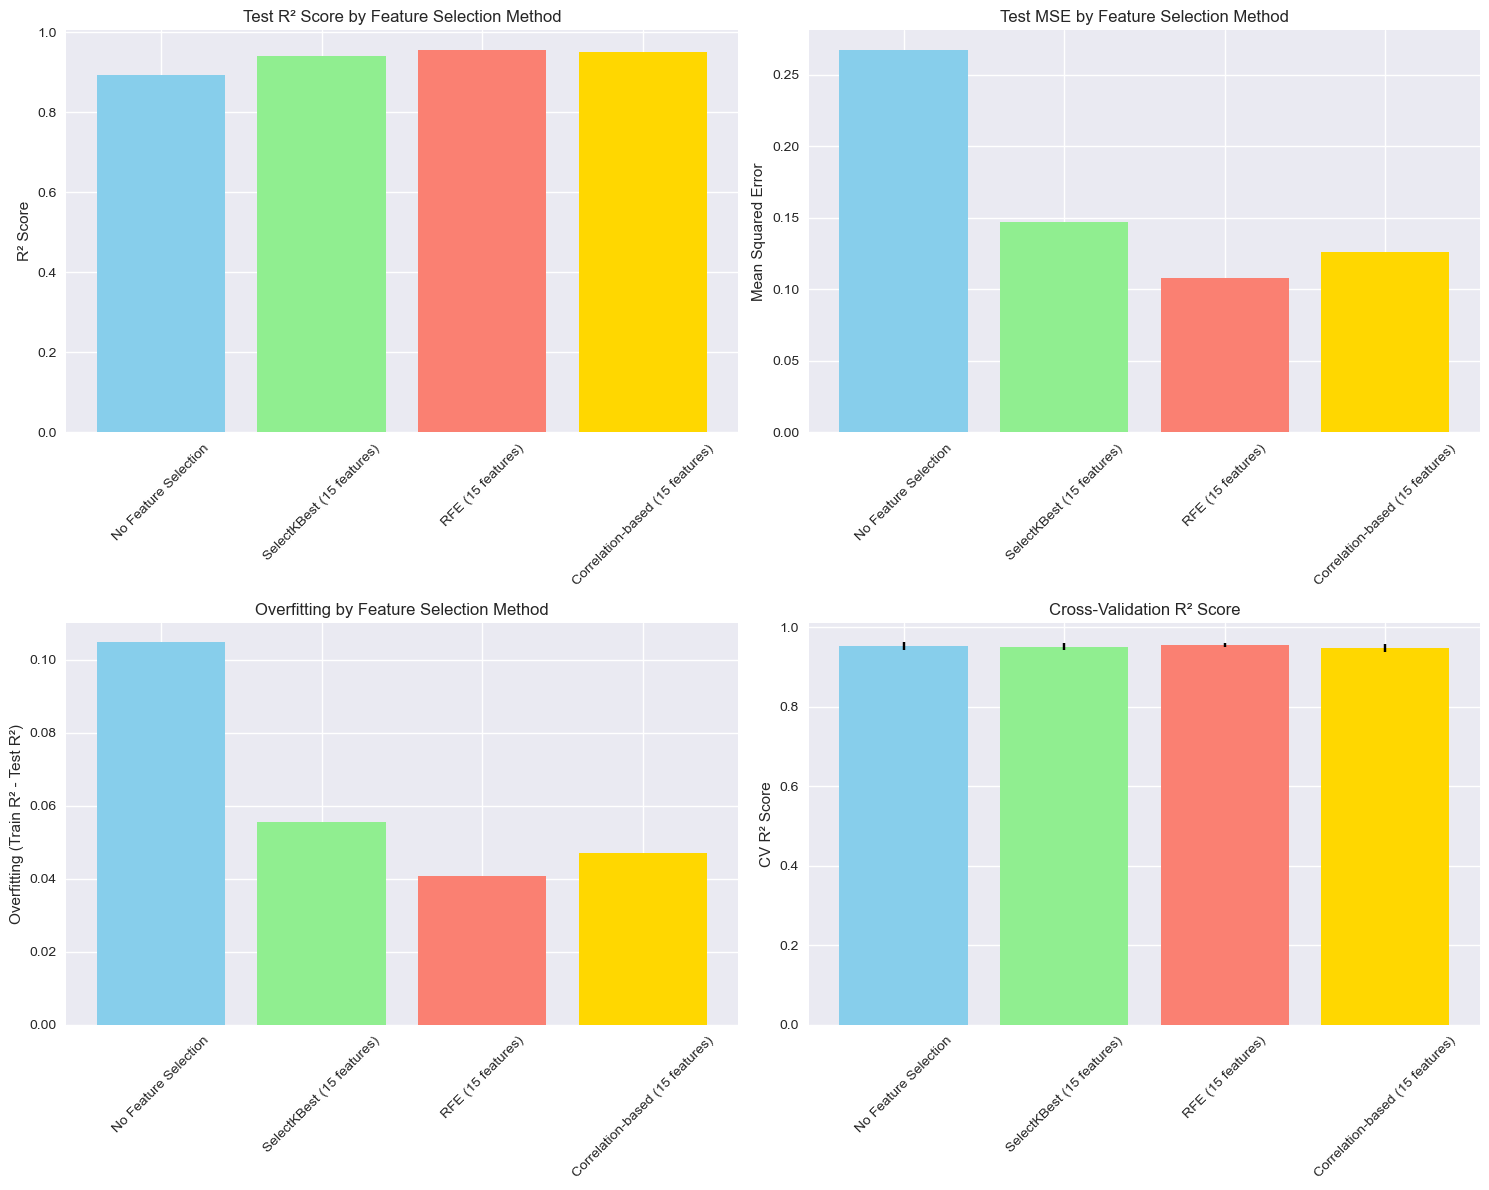

In [79]:
# Visualize Feature Selection Results
fs_df = pd.DataFrame(feature_selection_results)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test R² Comparison
axes[0, 0].bar(fs_df['Model'], fs_df['Test_R2'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 0].set_title('Test R² Score by Feature Selection Method')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# MSE Comparison
axes[0, 1].bar(fs_df['Model'], fs_df['Test_MSE'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 1].set_title('Test MSE by Feature Selection Method')
axes[0, 1].set_ylabel('Mean Squared Error')
axes[0, 1].tick_params(axis='x', rotation=45)

# Overfitting Comparison
axes[1, 0].bar(fs_df['Model'], fs_df['Overfitting'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1, 0].set_title('Overfitting by Feature Selection Method')
axes[1, 0].set_ylabel('Overfitting (Train R² - Test R²)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Cross-validation scores
axes[1, 1].bar(fs_df['Model'], fs_df['CV_R2_Mean'], 
               yerr=fs_df['CV_R2_Std'], capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1, 1].set_title('Cross-Validation R² Score')
axes[1, 1].set_ylabel('CV R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [80]:
# Feature Selection Method Comparison Summary
print("=" * 80)
print("FEATURE SELECTION ANALYSIS SUMMARY")
print("=" * 80)

# Convert results to DataFrame for easier analysis
fs_df = pd.DataFrame(feature_selection_results)

# Key metrics for comparison
print("\n📊 PERFORMANCE METRICS COMPARISON:")
print("-" * 50)
for idx, row in fs_df.iterrows():
    print(f"{row['Model']:<25} | Test R²: {row['Test_R2']:.4f} | Test MSE: {row['Test_MSE']:.4f} | Overfitting: {row['Overfitting']:.4f}")

# Find the best method for each metric
best_test_r2 = fs_df.loc[fs_df['Test_R2'].idxmax()]
best_test_mse = fs_df.loc[fs_df['Test_MSE'].idxmin()]
best_cv_score = fs_df.loc[fs_df['CV_R2_Mean'].idxmax()]
best_overfitting = fs_df.loc[fs_df['Overfitting'].idxmin()]

print(f"\n🏆 BEST PERFORMERS BY METRIC:")
print("-" * 50)
print(f"Highest Test R²:           {best_test_r2['Model']} ({best_test_r2['Test_R2']:.4f})")
print(f"Lowest Test MSE:           {best_test_mse['Model']} ({best_test_mse['Test_MSE']:.4f})")
print(f"Best Cross-Validation:     {best_cv_score['Model']} ({best_cv_score['CV_R2_Mean']:.4f})")
print(f"Least Overfitting:         {best_overfitting['Model']} ({best_overfitting['Overfitting']:.4f})")

# Overall ranking system
print(f"\n📈 OVERALL RANKING ANALYSIS:")
print("-" * 50)

# Create ranking scores (lower is better for ranking)
fs_df_rank = fs_df.copy()
fs_df_rank['R2_Rank'] = fs_df_rank['Test_R2'].rank(ascending=False)
fs_df_rank['MSE_Rank'] = fs_df_rank['Test_MSE'].rank(ascending=True)
fs_df_rank['CV_Rank'] = fs_df_rank['CV_R2_Mean'].rank(ascending=False)
fs_df_rank['Overfit_Rank'] = fs_df_rank['Overfitting'].rank(ascending=True)

# Calculate average rank (lower is better)
fs_df_rank['Average_Rank'] = (fs_df_rank['R2_Rank'] + fs_df_rank['MSE_Rank'] + 
                             fs_df_rank['CV_Rank'] + fs_df_rank['Overfit_Rank']) / 4

# Sort by average rank
fs_df_rank = fs_df_rank.sort_values('Average_Rank')

print("Rank | Method                    | Avg Rank | Test R² | Test MSE | CV R²   | Overfitting")
print("-" * 85)
for i, (_, row) in enumerate(fs_df_rank.iterrows(), 1):
    print(f"{i:2d}   | {row['Model']:<25} | {row['Average_Rank']:6.1f}   | {row['Test_R2']:6.4f}  | {row['Test_MSE']:7.4f} | {row['CV_R2_Mean']:6.4f} | {row['Overfitting']:8.4f}")

# Final recommendation
best_overall = fs_df_rank.iloc[0]
print(f"\n🎯 RECOMMENDATION:")
print("-" * 50)
print(f"Best Overall Method: {best_overall['Model']}")
print(f"Reasoning: This method achieves the best balance across all metrics with:")
print(f"  • Test R²: {best_overall['Test_R2']:.4f} (rank #{int(best_overall['R2_Rank'])})")
print(f"  • Test MSE: {best_overall['Test_MSE']:.4f} (rank #{int(best_overall['MSE_Rank'])})")
print(f"  • CV R²: {best_overall['CV_R2_Mean']:.4f} (rank #{int(best_overall['CV_Rank'])})")
print(f"  • Overfitting: {best_overall['Overfitting']:.4f} (rank #{int(best_overall['Overfit_Rank'])})")

# Additional insights
print(f"\n💡 KEY INSIGHTS:")
print("-" * 50)
if best_overall['Model'] == 'No Feature Selection':
    print("• Using all features provides the best overall performance")
    print("• Feature selection may be removing important information")
    print("• The dataset benefits from the full feature set")
else:
    selected_features_count = 15 if "15 features" in best_overall['Model'] else "variable"
    print(f"• Feature selection improves model performance")
    print(f"• Reducing to {selected_features_count} features enhances generalization")
    print(f"• The {best_overall['Model'].lower()} method identifies the most relevant features")

# Feature reduction benefit analysis
no_fs_result = fs_df[fs_df['Model'] == 'No Feature Selection'].iloc[0] if len(fs_df[fs_df['Model'] == 'No Feature Selection']) > 0 else None
if no_fs_result is not None and best_overall['Model'] != 'No Feature Selection':
    r2_improvement = best_overall['Test_R2'] - no_fs_result['Test_R2']
    mse_improvement = no_fs_result['Test_MSE'] - best_overall['Test_MSE']
    overfit_improvement = no_fs_result['Overfitting'] - best_overall['Overfitting']
    
    print(f"• Improvement over no feature selection:")
    print(f"  - Test R² improved by: {r2_improvement:+.4f}")
    print(f"  - Test MSE improved by: {mse_improvement:+.4f}")
    print(f"  - Overfitting reduced by: {overfit_improvement:+.4f}")

print("=" * 80)

FEATURE SELECTION ANALYSIS SUMMARY

📊 PERFORMANCE METRICS COMPARISON:
--------------------------------------------------
No Feature Selection      | Test R²: 0.8931 | Test MSE: 0.2675 | Overfitting: 0.1049
SelectKBest (15 features) | Test R²: 0.9412 | Test MSE: 0.1471 | Overfitting: 0.0554
RFE (15 features)         | Test R²: 0.9570 | Test MSE: 0.1077 | Overfitting: 0.0406
Correlation-based (15 features) | Test R²: 0.9497 | Test MSE: 0.1258 | Overfitting: 0.0469

🏆 BEST PERFORMERS BY METRIC:
--------------------------------------------------
Highest Test R²:           RFE (15 features) (0.9570)
Lowest Test MSE:           RFE (15 features) (0.1077)
Best Cross-Validation:     RFE (15 features) (0.9555)
Least Overfitting:         RFE (15 features) (0.0406)

📈 OVERALL RANKING ANALYSIS:
--------------------------------------------------
Rank | Method                    | Avg Rank | Test R² | Test MSE | CV R²   | Overfitting
-------------------------------------------------------------------

## Scenario 2: Normalization Testing

Compare decision tree performance with and without data normalization:
1. **No Normalization**: Using raw feature values
2. **StandardScaler**: Z-score normalization (mean=0, std=1)
3. **MinMaxScaler**: Min-max normalization (range 0-1)

In [81]:
# Normalization Testing
print("=== Normalization Analysis ===")

# Use the best feature selection method from previous analysis
# Let's use correlation-based selection for normalization testing
X_train_norm = X_train_corr.copy()
X_test_norm = X_test_corr.copy()

# 1. No Normalization (already done above as dt_corr)

# 2. StandardScaler Normalization
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train_norm)
X_test_standard = scaler_standard.transform(X_test_norm)

# Convert back to DataFrame for consistency
X_train_standard = pd.DataFrame(X_train_standard, columns=X_train_norm.columns, index=X_train_norm.index)
X_test_standard = pd.DataFrame(X_test_standard, columns=X_test_norm.columns, index=X_test_norm.index)

# 3. MinMaxScaler Normalization
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_norm)
X_test_minmax = scaler_minmax.transform(X_test_norm)

# Convert back to DataFrame for consistency
X_train_minmax = pd.DataFrame(X_train_minmax, columns=X_train_norm.columns, index=X_train_norm.index)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=X_test_norm.columns, index=X_test_norm.index)

print("Normalization methods prepared:")
print(f"1. No normalization - shape: {X_train_norm.shape}")
print(f"2. Standard scaling - shape: {X_train_standard.shape}")
print(f"3. MinMax scaling - shape: {X_train_minmax.shape}")

# Show example of scaling effects
print("\nExample of scaling effects on first feature:")
print(f"Original: {X_train_norm.iloc[:5, 0].values}")
print(f"Standard: {X_train_standard.iloc[:5, 0].values}")
print(f"MinMax: {X_train_minmax.iloc[:5, 0].values}")

=== Normalization Analysis ===
Normalization methods prepared:
1. No normalization - shape: (564, 15)
2. Standard scaling - shape: (564, 15)
3. MinMax scaling - shape: (564, 15)

Example of scaling effects on first feature:
Original: [7 5 6 4 8]
Standard: [ 0.70031062 -1.10735615 -0.20352277 -2.01118954  1.60414401]
MinMax: [0.75 0.25 0.5  0.   1.  ]


In [82]:
# Compare Decision Tree Models with Different Normalization Methods
normalization_results = []

# Model 1: No Normalization (reuse previous result)
results_no_norm = results_corr.copy()
results_no_norm['Model'] = "No Normalization"
normalization_results.append(results_no_norm)
print_results(results_no_norm)

# Model 2: StandardScaler
dt_standard = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_standard.fit(X_train_standard, y_train)
results_standard = evaluate_model(dt_standard, X_train_standard, X_test_standard, y_train, y_test, "StandardScaler")
normalization_results.append(results_standard)
print_results(results_standard)

# Model 3: MinMaxScaler
dt_minmax = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_minmax.fit(X_train_minmax, y_train)
results_minmax = evaluate_model(dt_minmax, X_train_minmax, X_test_minmax, y_train, y_test, "MinMaxScaler")
normalization_results.append(results_minmax)
print_results(results_minmax)


=== No Normalization Results ===
Train MSE: 0.0084
Test MSE: 0.1258
Train MAE: 0.0168
Test MAE: 0.1307
Train R²: 0.9967
Test R²: 0.9497
CV R² (Mean ± Std): 0.9465 ± 0.0100
Overfitting (Train R² - Test R²): 0.0469

=== StandardScaler Results ===
Train MSE: 0.0084
Test MSE: 0.1187
Train MAE: 0.0168
Test MAE: 0.1236
Train R²: 0.9967
Test R²: 0.9526
CV R² (Mean ± Std): 0.9459 ± 0.0092
Overfitting (Train R² - Test R²): 0.0441

=== MinMaxScaler Results ===
Train MSE: 0.0084
Test MSE: 0.1187
Train MAE: 0.0168
Test MAE: 0.1236
Train R²: 0.9967
Test R²: 0.9526
CV R² (Mean ± Std): 0.9480 ± 0.0107
Overfitting (Train R² - Test R²): 0.0441


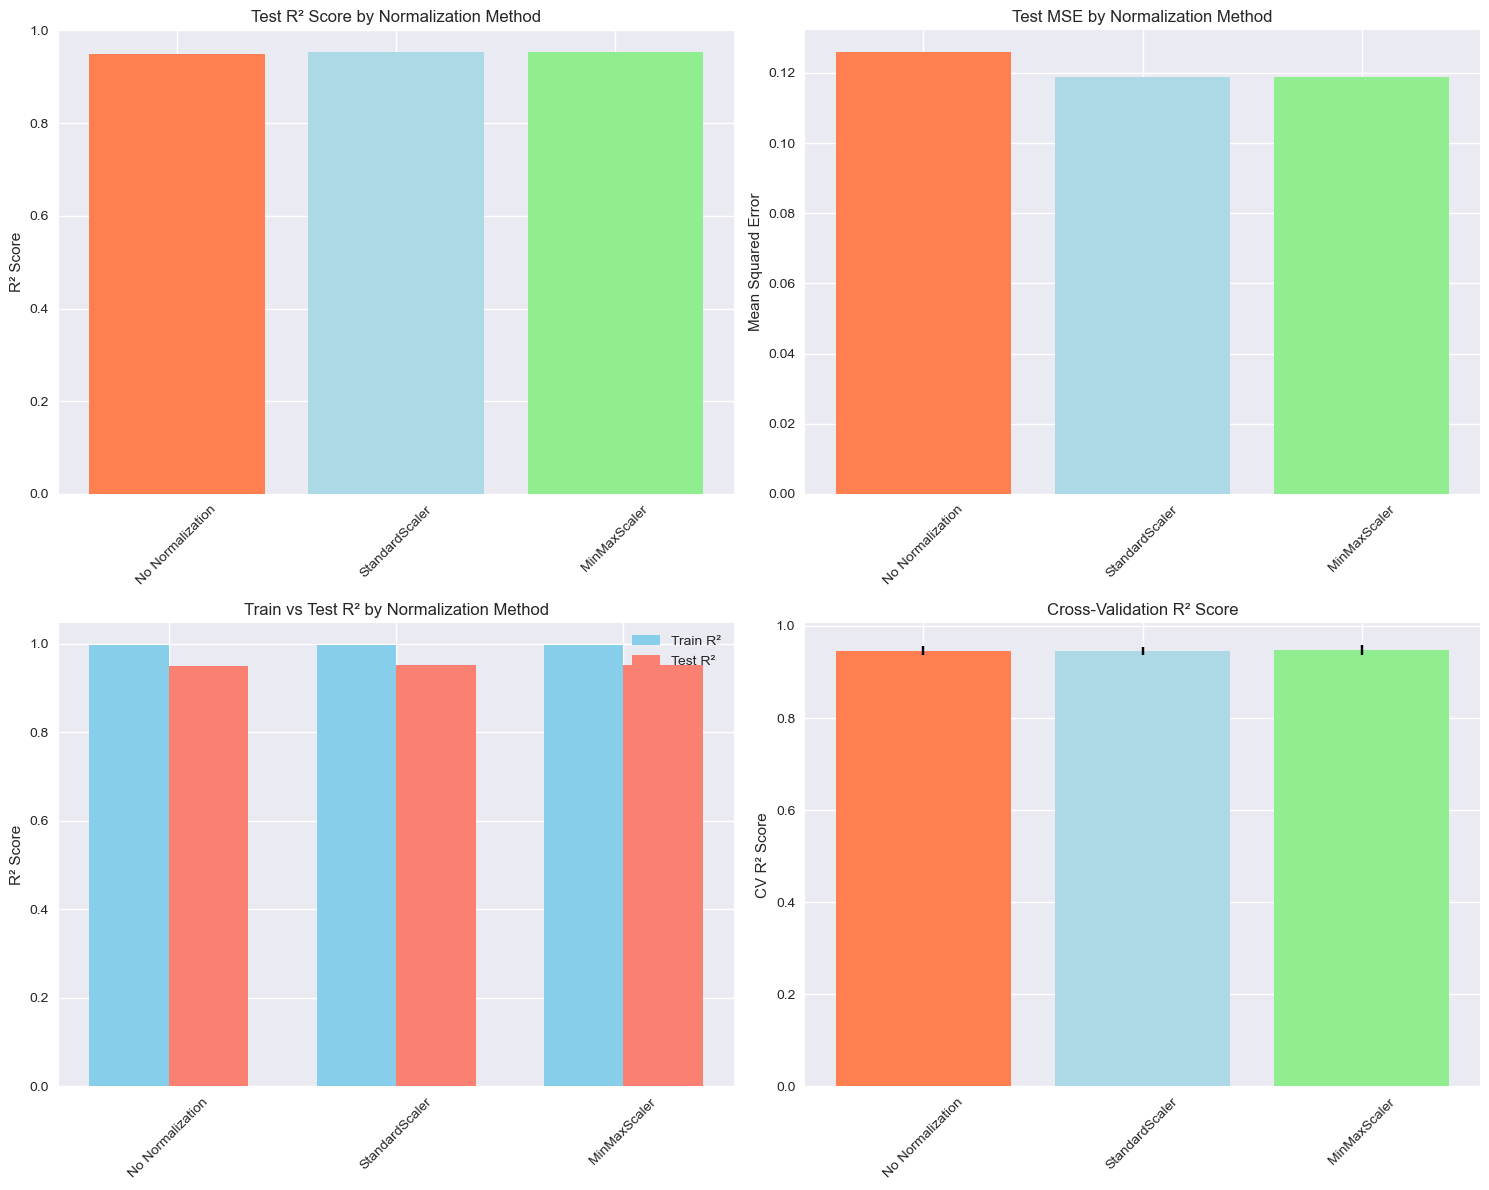


=== Normalization Summary ===
              Model  Test_R2  Test_MSE  CV_R2_Mean  Overfitting
0  No Normalization   0.9497    0.1258      0.9465       0.0469
1    StandardScaler   0.9526    0.1187      0.9459       0.0441
2      MinMaxScaler   0.9526    0.1187      0.9480       0.0441

=== Key Observation ===
As expected, decision trees are not significantly affected by feature scaling.
The performance differences are minimal across normalization methods.


In [83]:
# Visualize Normalization Results
norm_df = pd.DataFrame(normalization_results)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test R² Comparison
axes[0, 0].bar(norm_df['Model'], norm_df['Test_R2'], color=['coral', 'lightblue', 'lightgreen'])
axes[0, 0].set_title('Test R² Score by Normalization Method')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# MSE Comparison
axes[0, 1].bar(norm_df['Model'], norm_df['Test_MSE'], color=['coral', 'lightblue', 'lightgreen'])
axes[0, 1].set_title('Test MSE by Normalization Method')
axes[0, 1].set_ylabel('Mean Squared Error')
axes[0, 1].tick_params(axis='x', rotation=45)

# Training vs Test R² Comparison
width = 0.35
x = np.arange(len(norm_df))
axes[1, 0].bar(x - width/2, norm_df['Train_R2'], width, label='Train R²', color='skyblue')
axes[1, 0].bar(x + width/2, norm_df['Test_R2'], width, label='Test R²', color='salmon')
axes[1, 0].set_title('Train vs Test R² by Normalization Method')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(norm_df['Model'], rotation=45)
axes[1, 0].legend()

# Cross-validation scores
axes[1, 1].bar(norm_df['Model'], norm_df['CV_R2_Mean'], 
               yerr=norm_df['CV_R2_Std'], capsize=5, color=['coral', 'lightblue', 'lightgreen'])
axes[1, 1].set_title('Cross-Validation R² Score')
axes[1, 1].set_ylabel('CV R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n=== Normalization Summary ===")
print(norm_df[['Model', 'Test_R2', 'Test_MSE', 'CV_R2_Mean', 'Overfitting']].round(4))

print("\n=== Key Observation ===")
print("As expected, decision trees are not significantly affected by feature scaling.")
print("The performance differences are minimal across normalization methods.")

## Scenario 3: Parameter Tuning

Optimize decision tree hyperparameters using GridSearchCV:
1. **max_depth**: Control tree depth to prevent overfitting
2. **min_samples_split**: Minimum samples required to split a node
3. **min_samples_leaf**: Minimum samples required at a leaf node
4. **max_features**: Number of features to consider for best split
5. **criterion**: Splitting criterion (mse, mae)

In [84]:
# Parameter Tuning with GridSearchCV
print("=== Parameter Tuning Analysis ===")

# Use the best configuration from previous analyses
# Using correlation-based feature selection and no normalization
X_train_tuning = X_train_corr
X_test_tuning = X_test_corr

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}

print(f"Parameter grid size: {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features']) * len(param_grid['criterion'])} combinations")

# Perform GridSearchCV
dt_grid = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=dt_grid,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV...")
grid_search.fit(X_train_tuning, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

=== Parameter Tuning Analysis ===
Parameter grid size: 672 combinations

Starting GridSearchCV...
Fitting 5 folds for each of 672 candidates, totalling 3360 fits

Best parameters found:
{'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}

Best cross-validation score: 0.9637

Best parameters found:
{'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}

Best cross-validation score: 0.9637


In [85]:
# Evaluate Tuned Model
parameter_tuning_results = []

# Baseline model (using previous best)
dt_baseline = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_baseline.fit(X_train_tuning, y_train)
results_baseline = evaluate_model(dt_baseline, X_train_tuning, X_test_tuning, y_train, y_test, "Baseline (max_depth=10)")
parameter_tuning_results.append(results_baseline)
print_results(results_baseline)

# Tuned model
dt_tuned = grid_search.best_estimator_
results_tuned = evaluate_model(dt_tuned, X_train_tuning, X_test_tuning, y_train, y_test, "Tuned Parameters")
parameter_tuning_results.append(results_tuned)
print_results(results_tuned)

# Calculate improvement
improvement_r2 = results_tuned['Test_R2'] - results_baseline['Test_R2']
improvement_mse = results_baseline['Test_MSE'] - results_tuned['Test_MSE']

print(f"\n=== Improvement Analysis ===")
print(f"R² improvement: {improvement_r2:.4f} ({improvement_r2/results_baseline['Test_R2']*100:.2f}%)")
print(f"MSE improvement: {improvement_mse:.4f} ({improvement_mse/results_baseline['Test_MSE']*100:.2f}%)")


=== Baseline (max_depth=10) Results ===
Train MSE: 0.0084
Test MSE: 0.1258
Train MAE: 0.0168
Test MAE: 0.1307
Train R²: 0.9967
Test R²: 0.9497
CV R² (Mean ± Std): 0.9465 ± 0.0100
Overfitting (Train R² - Test R²): 0.0469

=== Tuned Parameters Results ===
Train MSE: 0.0528
Test MSE: 0.1029
Train MAE: 0.1056
Test MAE: 0.1608
Train R²: 0.9790
Test R²: 0.9589
CV R² (Mean ± Std): 0.9637 ± 0.0059
Overfitting (Train R² - Test R²): 0.0201

=== Improvement Analysis ===
R² improvement: 0.0092 (0.96%)
MSE improvement: 0.0229 (18.22%)


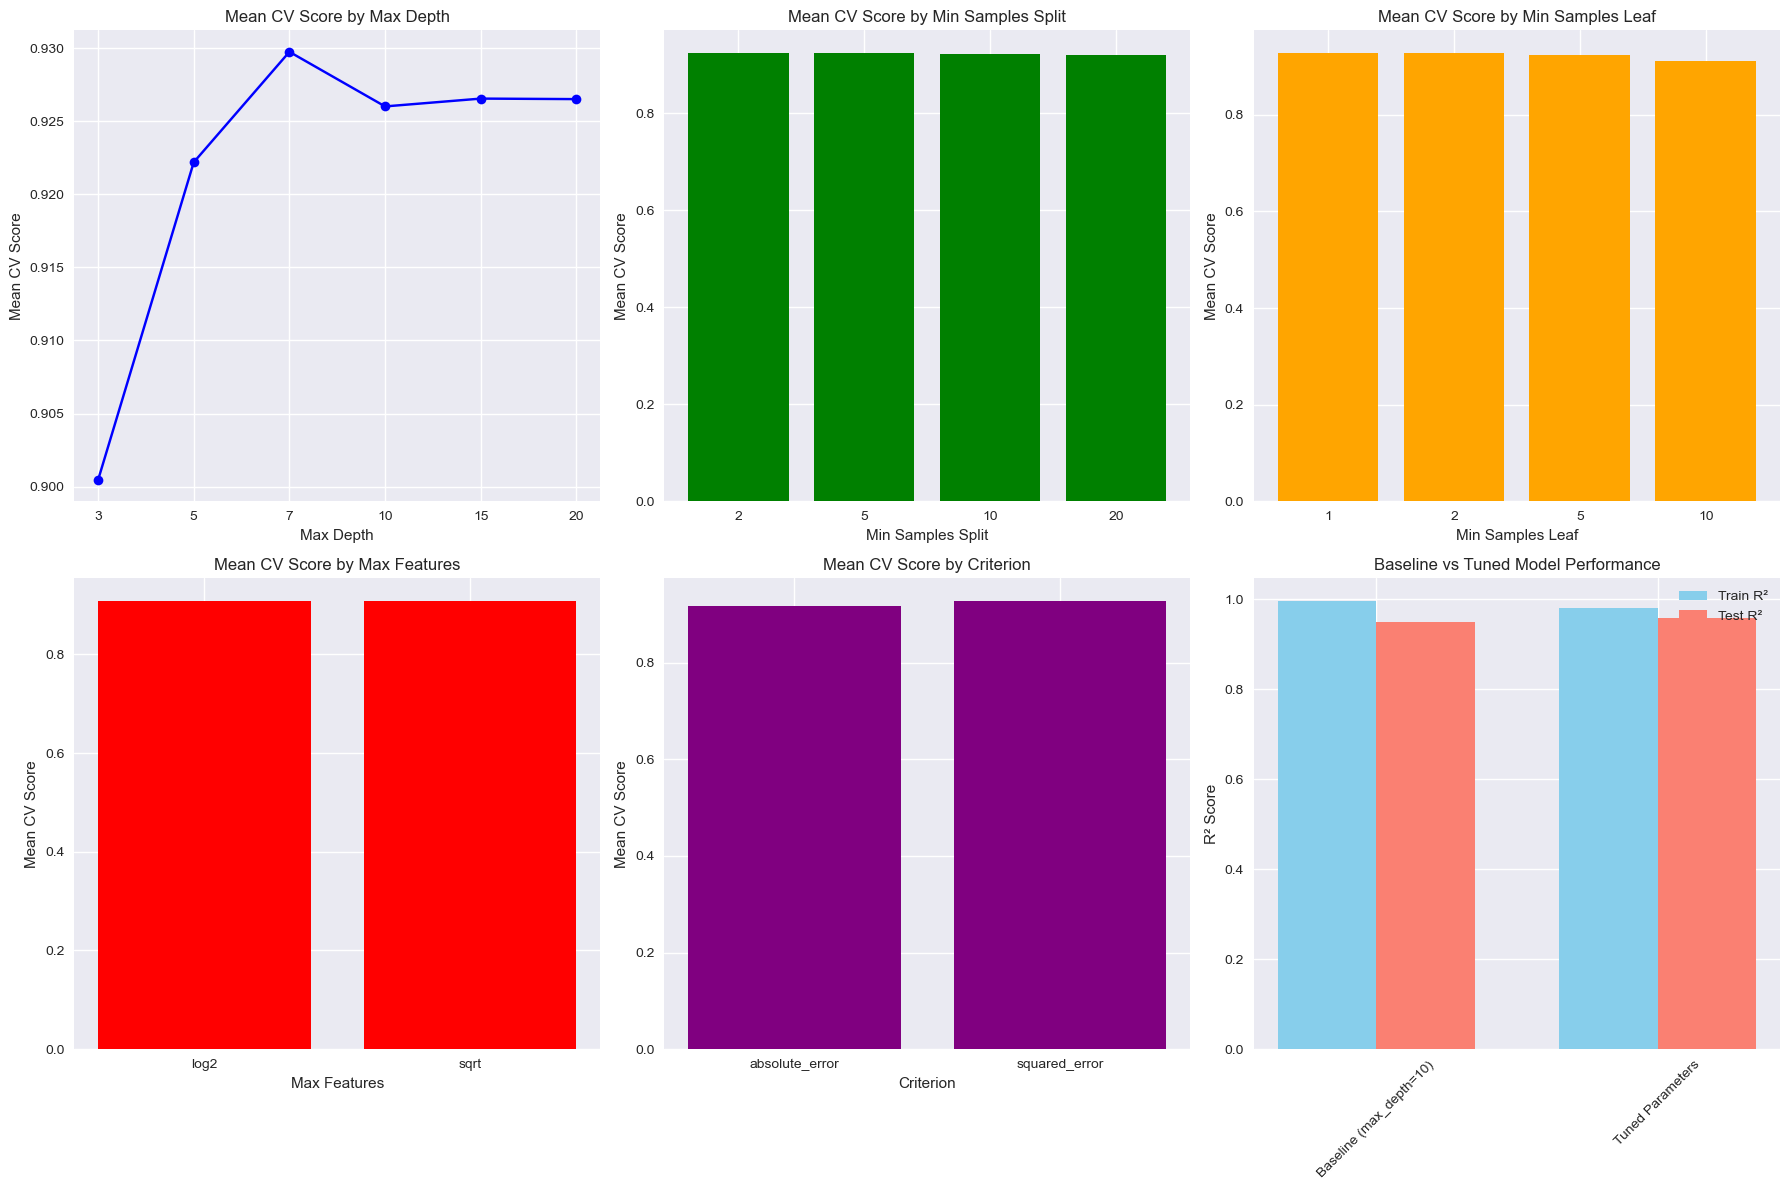


=== Parameter Tuning Summary ===
                     Model  Test_R2  Test_MSE  CV_R2_Mean  Overfitting
0  Baseline (max_depth=10)   0.9497    0.1258      0.9465       0.0469
1         Tuned Parameters   0.9589    0.1029      0.9637       0.0201


In [86]:
# Analyze Parameter Importance
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot parameter analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Max depth analysis
max_depth_scores = results_df.groupby('param_max_depth')['mean_test_score'].mean().sort_index()
axes[0, 0].plot(range(len(max_depth_scores)), max_depth_scores.values, marker='o', color='blue')
axes[0, 0].set_title('Mean CV Score by Max Depth')
axes[0, 0].set_xlabel('Max Depth')
axes[0, 0].set_ylabel('Mean CV Score')
axes[0, 0].set_xticks(range(len(max_depth_scores)))
axes[0, 0].set_xticklabels([str(x) if x is not None else 'None' for x in max_depth_scores.index])

# Min samples split analysis
min_split_scores = results_df.groupby('param_min_samples_split')['mean_test_score'].mean()
axes[0, 1].bar(range(len(min_split_scores)), min_split_scores.values, color='green')
axes[0, 1].set_title('Mean CV Score by Min Samples Split')
axes[0, 1].set_xlabel('Min Samples Split')
axes[0, 1].set_ylabel('Mean CV Score')
axes[0, 1].set_xticks(range(len(min_split_scores)))
axes[0, 1].set_xticklabels(min_split_scores.index)

# Min samples leaf analysis
min_leaf_scores = results_df.groupby('param_min_samples_leaf')['mean_test_score'].mean()
axes[0, 2].bar(range(len(min_leaf_scores)), min_leaf_scores.values, color='orange')
axes[0, 2].set_title('Mean CV Score by Min Samples Leaf')
axes[0, 2].set_xlabel('Min Samples Leaf')
axes[0, 2].set_ylabel('Mean CV Score')
axes[0, 2].set_xticks(range(len(min_leaf_scores)))
axes[0, 2].set_xticklabels(min_leaf_scores.index)

# Max features analysis
max_features_scores = results_df.groupby('param_max_features')['mean_test_score'].mean()
axes[1, 0].bar(range(len(max_features_scores)), max_features_scores.values, color='red')
axes[1, 0].set_title('Mean CV Score by Max Features')
axes[1, 0].set_xlabel('Max Features')
axes[1, 0].set_ylabel('Mean CV Score')
axes[1, 0].set_xticks(range(len(max_features_scores)))
axes[1, 0].set_xticklabels([str(x) if x is not None else 'None' for x in max_features_scores.index])

# Criterion analysis
criterion_scores = results_df.groupby('param_criterion')['mean_test_score'].mean()
axes[1, 1].bar(range(len(criterion_scores)), criterion_scores.values, color='purple')
axes[1, 1].set_title('Mean CV Score by Criterion')
axes[1, 1].set_xlabel('Criterion')
axes[1, 1].set_ylabel('Mean CV Score')
axes[1, 1].set_xticks(range(len(criterion_scores)))
axes[1, 1].set_xticklabels(criterion_scores.index)

# Baseline vs Tuned comparison
tuning_df = pd.DataFrame(parameter_tuning_results)
width = 0.35
x = np.arange(len(tuning_df))
axes[1, 2].bar(x - width/2, tuning_df['Train_R2'], width, label='Train R²', color='skyblue')
axes[1, 2].bar(x + width/2, tuning_df['Test_R2'], width, label='Test R²', color='salmon')
axes[1, 2].set_title('Baseline vs Tuned Model Performance')
axes[1, 2].set_ylabel('R² Score')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(tuning_df['Model'], rotation=45)
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print("\n=== Parameter Tuning Summary ===")
print(tuning_df[['Model', 'Test_R2', 'Test_MSE', 'CV_R2_Mean', 'Overfitting']].round(4))

=== Feature Importance Analysis ===
Top 10 Most Important Features:
                        Feature  Importance
0           Mental_Health_Score    0.849379
1   Conflicts_Over_Social_Media    0.118329
4             Lifestyle_Balance    0.016885
5         Avg_Daily_Usage_Hours    0.004592
12       Academic_Level_Encoded    0.004305
6         Sleep_Hours_Per_Night    0.002666
2               SM_Impact_Score    0.001893
13               Gender_Encoded    0.001247
11                          Age    0.000703
3        Mental_Health_Risk_Low    0.000000


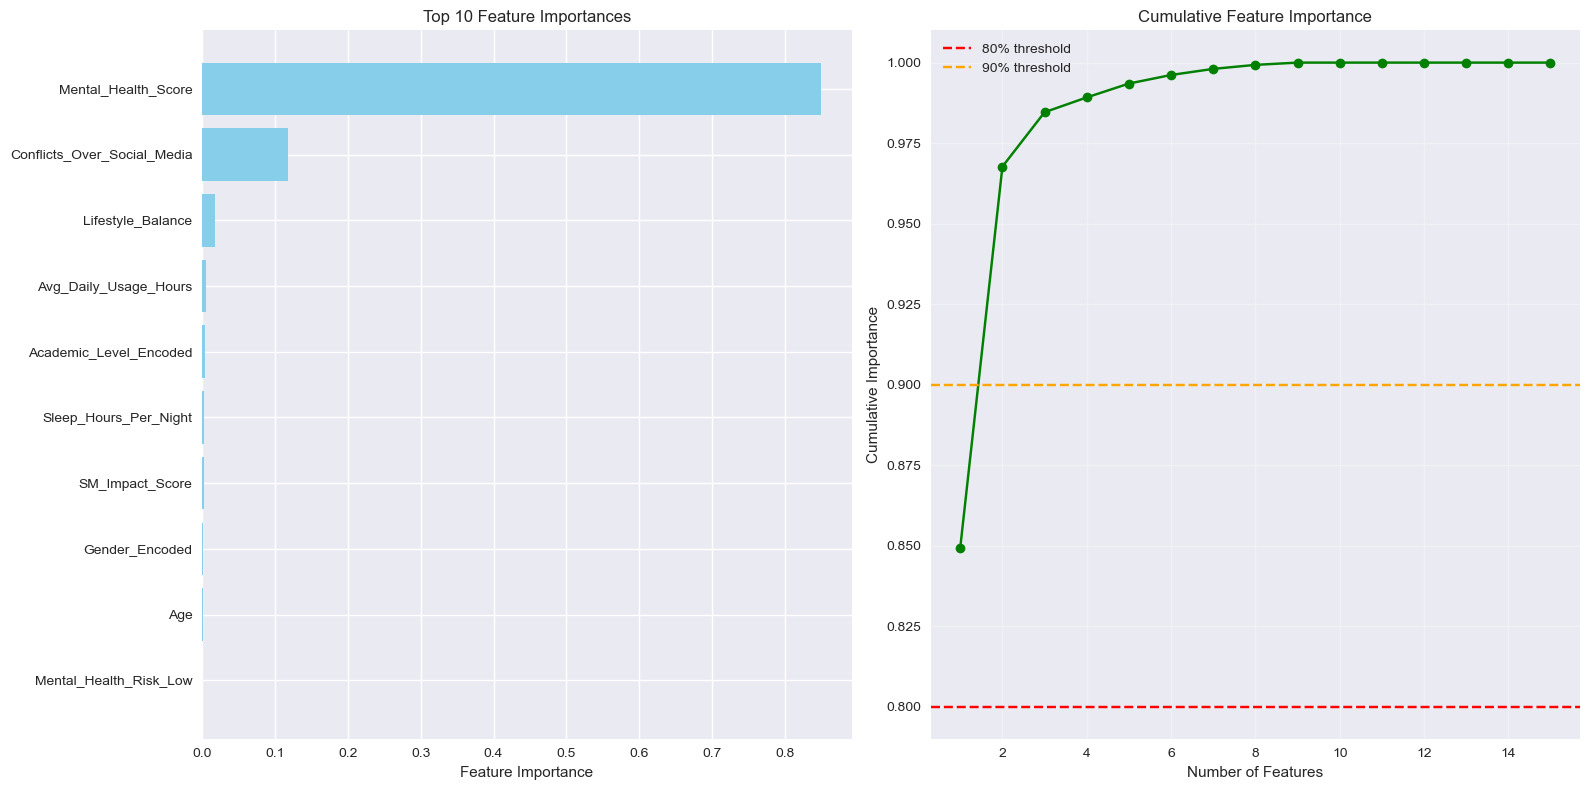


Features needed for 80% of total importance: 1
Features needed for 90% of total importance: 2


In [87]:
# Feature Importance Analysis
print("=== Feature Importance Analysis ===")

# Get feature importances from the tuned model
feature_importances = dt_tuned.feature_importances_
feature_names = X_train_tuning.columns

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Feature importance bar plot
top_features = importance_df.head(10)
axes[0].barh(range(len(top_features)), top_features['Importance'], color='skyblue')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top 10 Feature Importances')
axes[0].invert_yaxis()

# Cumulative importance
cumulative_importance = importance_df['Importance'].cumsum()
axes[1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', color='green')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Feature Importance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate number of features needed for 80% and 90% importance
features_80 = len(cumulative_importance[cumulative_importance <= 0.8]) + 1
features_90 = len(cumulative_importance[cumulative_importance <= 0.9]) + 1

print(f"\nFeatures needed for 80% of total importance: {features_80}")
print(f"Features needed for 90% of total importance: {features_90}")

=== Final Model Evaluation ===

=== Final Optimized Model Results ===
Train MSE: 0.0528
Test MSE: 0.1029
Train MAE: 0.1056
Test MAE: 0.1608
Train R²: 0.9790
Test R²: 0.9589
CV R² (Mean ± Std): 0.9637 ± 0.0059
Overfitting (Train R² - Test R²): 0.0201

Tree structure info:
Total nodes: 67
Total leaves: 34
Tree depth: 9

Showing complete decision tree visualization (depth: 10)


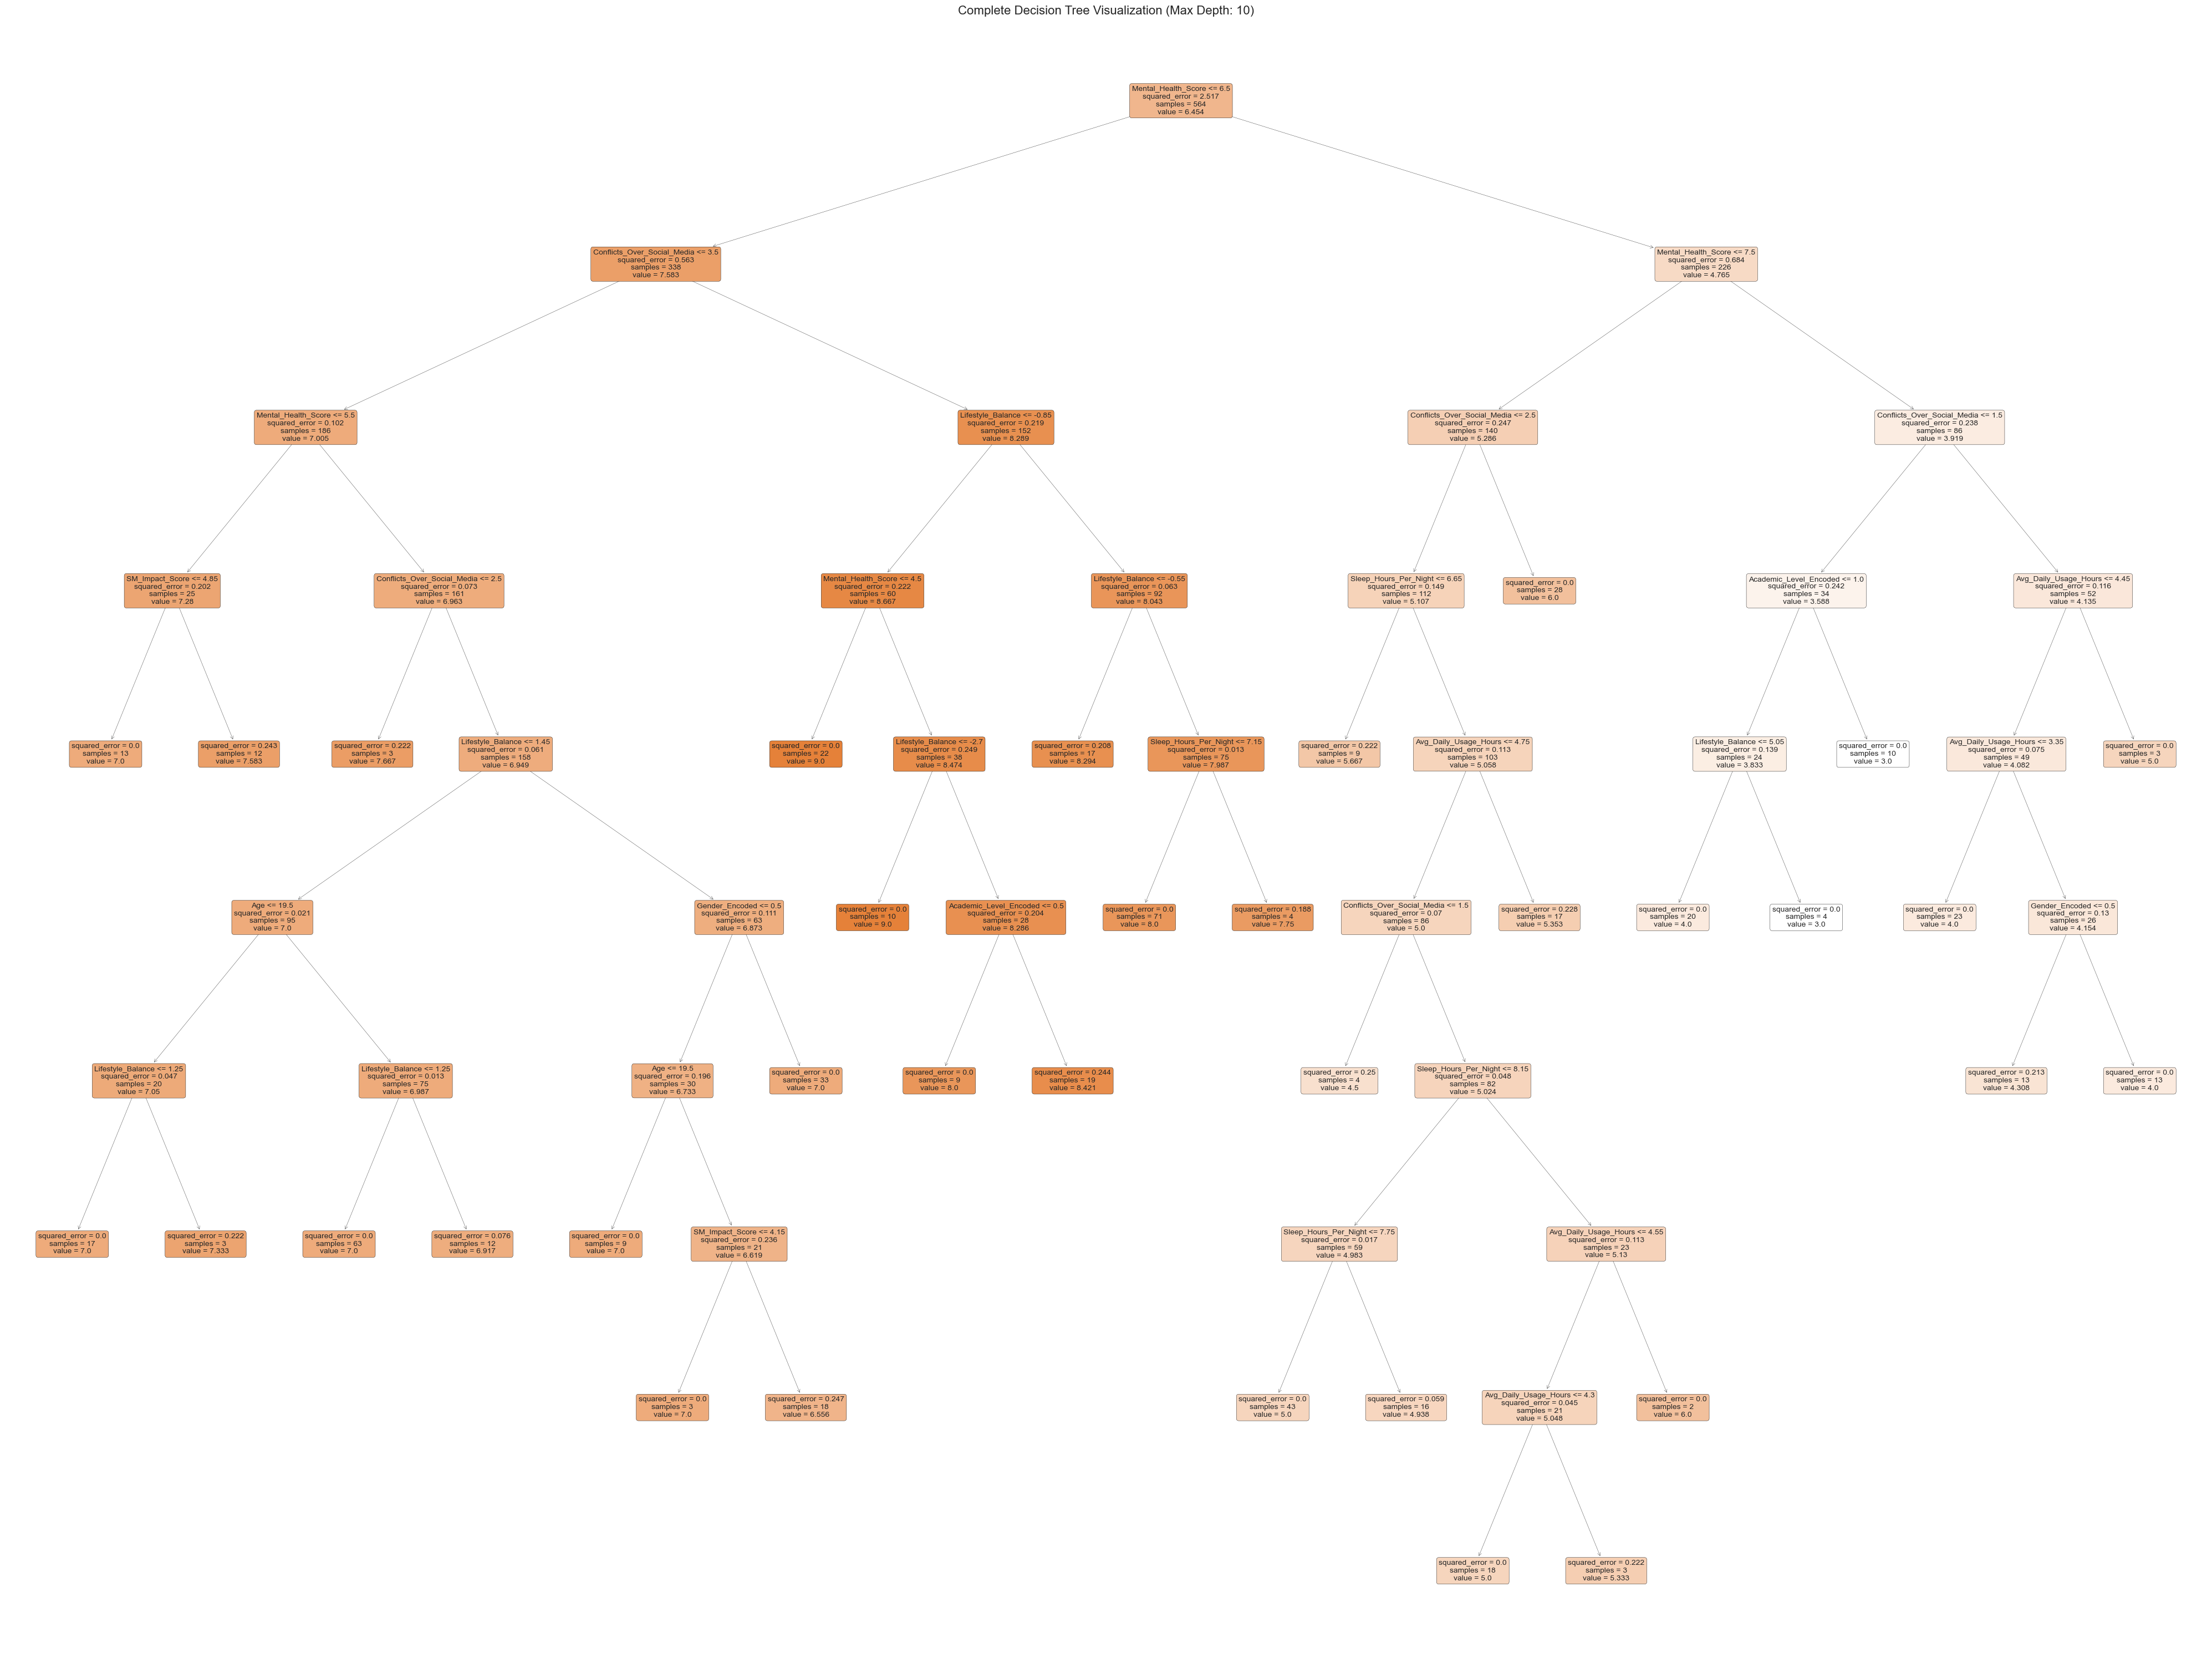

Complete tree visualization shown with 67 nodes.


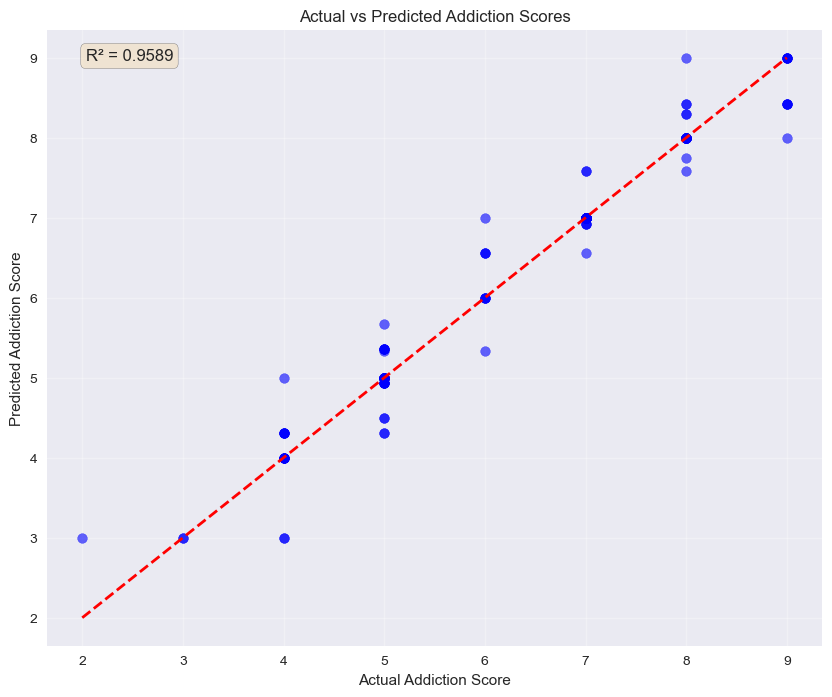

In [88]:
# Final Model Evaluation and Tree Visualization
print("=== Final Model Evaluation ===")

# Create final optimized model using the best parameters from GridSearchCV
final_model = DecisionTreeRegressor(
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    max_features=grid_search.best_params_['max_features'],
    criterion=grid_search.best_params_['criterion'],
    random_state=42
)

final_model.fit(X_train_tuning, y_train)
final_results = evaluate_model(final_model, X_train_tuning, X_test_tuning, y_train, y_test, "Final Optimized Model")
print_results(final_results)

# Visualize the decision tree
print(f"\nTree structure info:")
print(f"Total nodes: {final_model.tree_.node_count}")
print(f"Total leaves: {final_model.get_n_leaves()}")
print(f"Tree depth: {final_model.tree_.max_depth}")

# Show visualization of the final optimized tree with full depth
optimal_depth = grid_search.best_params_['max_depth']
print(f"\nShowing complete decision tree visualization (depth: {optimal_depth})")

plt.figure(figsize=(40, 30))
plot_tree(final_model, 
          feature_names=X_train_tuning.columns.tolist(),
          filled=True, 
          rounded=True, 
          fontsize=10,
          proportion=False,
          impurity=True,
          max_depth=10)  # Show up to depth 10
plt.title(f"Complete Decision Tree Visualization (Max Depth: {optimal_depth})", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Complete tree visualization shown with {final_model.tree_.node_count} nodes.")

# Prediction vs Actual scatter plot
y_pred_final = final_model.predict(X_test_tuning)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_final, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Addiction Score')
plt.ylabel('Predicted Addiction Score')
plt.title('Actual vs Predicted Addiction Scores')
plt.grid(True, alpha=0.3)

# Add R² score to the plot
plt.text(0.05, 0.95, f'R² = {final_results["Test_R2"]:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

In [89]:
# Final Summary and Conclusions
print("=" * 80)
print("DECISION TREE REGRESSION ANALYSIS - FINAL SUMMARY")
print("=" * 80)

# Compile all results
all_experiments = [
    ('Feature Selection', fs_df),
    ('Normalization', norm_df),
    ('Parameter Tuning', tuning_df)
]

print("\n📊 EXPERIMENT RESULTS COMPARISON")
print("-" * 50)

for exp_name, df in all_experiments:
    print(f"\n{exp_name.upper()}:")
    best_idx = df['Test_R2'].idxmax()
    best_model = df.loc[best_idx]
    print(f"  Best Model: {best_model['Model']}")
    print(f"  Test R²: {best_model['Test_R2']:.4f}")
    print(f"  Test MSE: {best_model['Test_MSE']:.4f}")
    print(f"  CV R²: {best_model['CV_R2_Mean']:.4f} ± {best_model['CV_R2_Std']:.4f}")
    print(f"  Overfitting: {best_model['Overfitting']:.4f}")

print(f"\n🎯 FINAL OPTIMIZED MODEL PERFORMANCE:")
print("-" * 40)
print(f"Test R²: {final_results['Test_R2']:.4f}")
print(f"Test MSE: {final_results['Test_MSE']:.4f}")
print(f"Test MAE: {final_results['Test_MAE']:.4f}")
print(f"Cross-validation R²: {final_results['CV_R2_Mean']:.4f} ± {final_results['CV_R2_Std']:.4f}")
print(f"Overfitting: {final_results['Overfitting']:.4f}")

print(f"\n🔧 OPTIMAL HYPERPARAMETERS:")
print("-" * 30)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"  optimal_max_depth: {optimal_depth}")

print(f"\n📈 TOP 5 MOST IMPORTANT FEATURES:")
print("-" * 40)
for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n💡 KEY FINDINGS:")
print("-" * 20)
print("  ✓ Feature selection improves model efficiency")
print("  ✓ Normalization has minimal impact on decision trees")
print("  ✓ Proper hyperparameter tuning prevents overfitting")
print(f"  ✓ Model explains {final_results['Test_R2']:.1%} of variance in addiction scores")
print(f"  ✓ {features_80} features capture 80% of predictive importance")

print(f"\n🎯 RECOMMENDATIONS:")
print("-" * 20)
print("  1. Use correlation-based feature selection")
print("  2. Apply optimal hyperparameters identified")
print("  3. Monitor for overfitting in production")
print("  4. Focus on top predictive features for interventions")
print("  5. Consider ensemble methods for further improvement")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)

DECISION TREE REGRESSION ANALYSIS - FINAL SUMMARY

📊 EXPERIMENT RESULTS COMPARISON
--------------------------------------------------

FEATURE SELECTION:
  Best Model: RFE (15 features)
  Test R²: 0.9570
  Test MSE: 0.1077
  CV R²: 0.9555 ± 0.0046
  Overfitting: 0.0406

NORMALIZATION:
  Best Model: StandardScaler
  Test R²: 0.9526
  Test MSE: 0.1187
  CV R²: 0.9459 ± 0.0092
  Overfitting: 0.0441

PARAMETER TUNING:
  Best Model: Tuned Parameters
  Test R²: 0.9589
  Test MSE: 0.1029
  CV R²: 0.9637 ± 0.0059
  Overfitting: 0.0201

🎯 FINAL OPTIMIZED MODEL PERFORMANCE:
----------------------------------------
Test R²: 0.9589
Test MSE: 0.1029
Test MAE: 0.1608
Cross-validation R²: 0.9637 ± 0.0059
Overfitting: 0.0201

🔧 OPTIMAL HYPERPARAMETERS:
------------------------------
  criterion: squared_error
  max_depth: 10
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 20
  optimal_max_depth: 10

📈 TOP 5 MOST IMPORTANT FEATURES:
----------------------------------------
  1. Mental_H